In [282]:
'''
#Libra
'''

import os
import re
import sys
import dask
import random
import argparse
import warnings
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from Bio.Align import substitution_matrices
from scipy.stats import ttest_1samp
from scipy.stats import shapiro
from collections import defaultdict
from Bio.Seq import Seq
from joblib import Parallel, delayed
warnings.filterwarnings('ignore')

In [283]:
'''
#Biological input data
'''

genome_f = '/home/yoann/Yoann_internship/data/Reekeekee/rooOceanUs1_genome.fa'
read_f   = '/home/yoann/Yoann_internship/results/rooOceanUs1/EAM_Yise2_SAG_r.fna'
cpu = 8

blosum = substitution_matrices.load('BLOSUM62')
for aa in 'GASPVTCILNDKQEMHFRYW' :
    blosum[aa]['*'] = -20

genome = ''
with open (genome_f,'r') as f1 :
	for l in f1 : 
		if not l.startswith('>') :
			genome += l.strip().replace('n','A').upper()

Declare each usefull functions : 

In [284]:
'''
Functions
'''


#Translate a given nucleotide sequence into the corresponding amino acid sequence
def translate(seq):
	table = {
		'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
		'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
		'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
		'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
		'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
		'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
		'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
		'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
		'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
		'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
		'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
		'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
		'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
		'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
		'TAC':'Y', 'TAT':'Y', 'TAA':'*', 'TAG':'*',
		'TGC':'C', 'TGT':'C', 'TGA':'*', 'TGG':'W',
	}
	protein =""
	if len(seq)%3 == 0:
		for i in range(0, len(seq), 3):
			codon = seq[i:i + 3]
			protein+= table[codon]
	return protein


#Give the DeltaS of each amino acid of a contig compared to the genome 
#(In LL, DeltaS is calculated for the contig between genome in region matching with an ORF)
def calc_delta_S(contig, startg, endg) :
    deltaS = list()
    contig_index = 0
    c_aa = translate(contig)
    for a in translate(genome[int(startg):int(endg)]) :                  
        deltaS.append(float(blosum[a][c_aa[contig_index]])-float(blosum[a][a])) #-20 penalty for stop codon is already set when importing the blosum matrix	
        contig_index += 1
    return deltaS

def calc_delta_S_reverse(contig, startg, endg) :
    deltaS = list()
    contig_index = 0
    c_aa = translate(Seq(contig).reverse_complement())
    for a in translate(Seq(genome[int(startg):int(endg)]).reverse_complement()) : #We reverse the read seq so the genome too. No reading frame issue cause ORFs are multiple of 3                  
        deltaS.append(float(blosum[a][c_aa[contig_index]])-float(blosum[a][a]))	
        contig_index += 1
    return deltaS


#In BWA output file, I need to parse the CIGAR to retrieve real match position
def extract_mapped_sequence(read_sequence, cigar_string, linee):
    mapped_length = 0
    mapped_sequence = ""
    r = ""
    
    for operation in re.findall(r"(\d+)([MIDNSHP=X])", cigar_string):
        length, op_type = operation
        length = int(length)

        if op_type in ["M", "=", "X"]:
            mapped_length += length
            mapped_sequence += read_sequence[:length]
            read_sequence = read_sequence[length:]            
        elif op_type in ("I","S","D") :
            read_sequence = read_sequence[length:]
        elif op_type == "H":
              r = linee
    if r == "" :
        return mapped_sequence[-mapped_length:]
    else:
        return r


#Calculate some information for the current line (This function is here to make the code more readable)
def calc_reads_infos(line) :
    line = line.split()
    mn      = int(line[3][5:])                        #Number of muation in this read
    r_start = int(line[0])                             #Start position of the read on the reference genome
    r_seq   = line[2]                                  #Read sequence
    r_match_seq = extract_mapped_sequence(r_seq, line[1], line[2])
    length  = (len(r_match_seq))                           #Read length
    
    return [mn, r_start, length, r_match_seq]


def log_likelihood(log_alpha_g, logit_beta_n, reads, Array_dS_part2): 
    
    #define gamma
    #calculate deltas and other info where gamma is used
    
    alpha_g =  tf.math.exp(log_alpha_g)
    #Calculate exp(alpha*deltaS)
    raw_exp_a_ds = tf.exp(tf.multiply(Array_dS_part3, alpha_g[:, np.newaxis, np.newaxis]))
    #Convert full column of 1 to zero : avoid a bias
    mask = tf.reduce_all(tf.equal(raw_exp_a_ds, 1.0), axis=0)
    product = tf.math.reduce_prod(tf.where(tf.expand_dims(mask, axis=0), tf.zeros_like(raw_exp_a_ds), raw_exp_a_ds), axis=0)
    F = tf.reduce_sum(product, axis=1)
    
    p3 = 0
    for i in sorted(reads):
        beta_ni = tf.math.sigmoid(logit_beta_n[i])
        p3 += tf.reduce_sum( tf.math.log( 1-beta_ni + (beta_ni/3) * F[reads[i][1]:reads[i][1]+reads[i][2]] ) )

    beta_n = tf.math.sigmoid(logit_beta_n)
    p_all = tf.reduce_sum(m_n*tf.math.log(beta_n/3)
              + (l_n - m_n)*tf.math.log(1-beta_n)
              + tf.reduce_sum(tf.multiply(Array_dS_part2, alpha_g), axis=1)
                         ) - p3
    print('p_all', p_all, '-p_all', -p_all)    
    return p_all

def neg_log_likelihood(log_alpha_g, logit_beta_n, reads, Array_dS_part2):
    return - log_likelihood(log_alpha_g, logit_beta_n, reads, Array_dS_part2)

Real code part :

In [62]:
%%time

'''
#BWA-MEME
'''

#I recommend to delete unused lines of the file before to write it on the hard disk to speed each steps with this file

os.system("bwa-meme index "+genome_f+" ; bwa-meme mem -t "+str(cpu)+" "+genome_f+" "+read_f+" \
                        | samtools sort --threads "+str(cpu)+" \
                        | samtools markdup -r -@ "+str(cpu)+" --output-fmt SAM - - \
                        | awk '$4!=0' \
                        | grep -v '^@' \
                        | cut -f4,6,10,12 \
                            > sorted.sam") #BWA, sort results, remove duplicate, select columns, remove match at position 0, save in a file

Looking to launch executable "/home/yoann/miniconda3/envs/tf/bin/bwa-meme_mode3.avx2", simd = _mode3.avx2
Launching executable "/home/yoann/miniconda3/envs/tf/bin/bwa-meme_mode3.avx2"
[bwa_index] Pack FASTA... 0.00 sec
* Entering FMI_search
init ticks = 1480487
ref seq len = 6816
binary seq ticks = 610249
build suffix-array ticks = 3693714
pos: 853, ref_seq_len__: 852
build fm-index ticks = 2276459
Total time taken: 0.0112
Looking to launch executable "/home/yoann/miniconda3/envs/tf/bin/bwa-meme_mode3.avx2", simd = _mode3.avx2
Launching executable "/home/yoann/miniconda3/envs/tf/bin/bwa-meme_mode3.avx2"


ref_seq_len = 6816
count = 0, 2030, 3408, 4786, 6816
BWT[1782] = 4
CP_SHIFT = 6, CP_MASK = 63
sizeof CP_OCC = 64
max_occ_ind = 106


-----------------------------
Executing in AVX2 mode!!
-----------------------------
* SA compression enabled with xfactor: 8
* Ref file: /home/yoann/Yoann_internship/data/Reekeekee/rooOceanUs1_genome.fa
* Entering FMI_search
* Index file found. Loading index from /home/yoann/Yoann_internship/data/Reekeekee/rooOceanUs1_genome.fa.bwt.2bit.64
* Reference seq len for bi-index = 6817
* sentinel-index: 1782
* Count:
0,	1
1,	2031
2,	3409
3,	4787
4,	6817

* Reading other elements of the index from files /home/yoann/Yoann_internship/data/Reekeekee/rooOceanUs1_genome.fa
* Index prefix: /home/yoann/Yoann_internship/data/Reekeekee/rooOceanUs1_genome.fa
* Read 0 ALT contigs
* Done reading Index!!
* Reading reference genome..
* Binary seq file = /home/yoann/Yoann_internship/data/Reekeekee/rooOceanUs1_genome.fa.0123
* Reference genome size: 6816 bp
* Done reading reference genome !!

------------------------------------------
1. Memory pre-allocation for Chaining: 1135.9148 MB
2. Memory pre-allocati

[0000] read_chunk: 80000000, work_chunk_size: 80000148, nseq: 809830
	[0000][ M::kt_pipeline] read 809830 sequences (80000148 bp)...
[0000] Calling mem_process_seqs.., task: 18
[0000] 1. Calling kt_for - worker_bwt
[0000] 2. Calling kt_for - worker_aln
[0000] 3. Calling kt_for - worker_sam
	[0000][ M::mem_process_seqs] Processed 809830 reads in 35.581 CPU sec, 5.232 real sec
[0000] read_chunk: 80000000, work_chunk_size: 80000025, nseq: 810454
	[0000][ M::kt_pipeline] read 810454 sequences (80000025 bp)...
[0000] Calling mem_process_seqs.., task: 19
[0000] 1. Calling kt_for - worker_bwt
[0000] 2. Calling kt_for - worker_aln
[0000] 3. Calling kt_for - worker_sam
	[0000][ M::mem_process_seqs] Processed 810454 reads in 35.706 CPU sec, 5.168 real sec
[0000] read_chunk: 80000000, work_chunk_size: 80000177, nseq: 811462
	[0000][ M::kt_pipeline] read 811462 sequences (80000177 bp)...
[0000] Calling mem_process_seqs.., task: 20
[0000] 1. Calling kt_for - worker_bwt
[0000] read_chunk: 80000000, 

[0000] read_chunk: 80000000, work_chunk_size: 80000091, nseq: 815562
	[0000][ M::kt_pipeline] read 815562 sequences (80000091 bp)...
[0000] 2. Calling kt_for - worker_aln
[0000] 3. Calling kt_for - worker_sam
	[0000][ M::mem_process_seqs] Processed 813466 reads in 37.057 CPU sec, 5.131 real sec
[0000] Reallocating initial memory allocations!!
[0000] Calling mem_process_seqs.., task: 40
[0000] 1. Calling kt_for - worker_bwt
[0000] read_chunk: 80000000, work_chunk_size: 80000052, nseq: 815034
	[0000][ M::kt_pipeline] read 815034 sequences (80000052 bp)...
[0000] 2. Calling kt_for - worker_aln
[0000] 3. Calling kt_for - worker_sam
	[0000][ M::mem_process_seqs] Processed 815562 reads in 36.310 CPU sec, 5.077 real sec
[0000] Calling mem_process_seqs.., task: 41
[0000] 1. Calling kt_for - worker_bwt
[0000] 2. Calling kt_for - worker_aln
[0000] 3. Calling kt_for - worker_sam
	[0000][ M::mem_process_seqs] Processed 815034 reads in 36.326 CPU sec, 5.052 real sec
[0000] read_chunk: 80000000, wor

0

In [285]:
'''
#ORFs from genome
'''

#Product ORF file for the current genome (orfipy) and import here (ORF_name = [start, end, alpha_value]) 
os.system("orfipy --procs "+str(cpu)+" --pep orfipy_peptide --min 30 --table 21 --ignore-case --outdir "+str(genome_f.split('/')[-1])+"_temp-orf "+genome_f) 
orfs = defaultdict(list)
with open (str(genome_f.split('/')[-1])+'_temp-orf/orfipy_peptide','r') as f1 :
	for l in f1 : 
		if l.startswith('>') :
			orfs[l.split()[0].lstrip('>')] = [int(re.search(r'\[(\d+)\-\d+\]',l).group(1)) , int(re.search(r'\[\d+\-(\d+)\]',l).group(1)), str(re.search(r'\(([+-])\)',l).group(1))]

orfipy version 0.0.4
Using translation table: Condylostoma Nuclear (transl_table=28) start: ['ATG'] stop: ['TAA', 'TAG', 'TGA']
Setting chunk size 999 MB. Procs 8
Logs will be saved to: rooOceanUs1_genome.fa_temp-orf/orfipy_2023_03_29_11_01_35.995893.log
Processed 1 sequences in 0.04 seconds


In [286]:
%%time

'''
#Retrieve reads from data and calculate part3 array
'''

#DeltaS have diffrent values and structure in part 2 and part 3 of the log likelihood. 
#This python code allow to calculate deltaS for both parts without comute several loops over orfs. Others data are 
#precompute such as m_n and l_n for each reads. In this way, we retrieve every mandatory information to calculate the
#log in a quite simple python code.

run_dS_part3_calc = True
Dict_dS_part3 = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
reads   = defaultdict(list)
mn_list = list()
ln_list = list()
nb = -1

with open ('sorted.sam','r') as f1 : 
    for line in f1 : 
        nb+=1
        print(line)
        reads[nb] = calc_reads_infos(line)
        mn_list.append(reads[nb][0])
        ln_list.append(reads[nb][2])
        if run_dS_part3_calc :    
            for orf in orfs :
                orf_start  = orfs[orf][0]
                orf_end    = orfs[orf][1]
                orf_strand = orfs[orf][2]
                ###Calculate deltaS for the third part, 1 time only! (for each orfs)

                for xi_pos in range(len(genome)):
                    for y in 'ATCG':
                        deltas = 0.0

                        if orf_start <= xi_pos <= orf_end :
                            xo = xi_pos - orf_start #Index of xi in ORF string
                            orf_seq = genome[orf_start : orf_end+1]

                            #Codon_orf will be different if the ORF is reverse or not
                            if orf_strand == '+' :
                                temp = orf_seq[:xo]+y+orf_seq[xo+1:] #Replace the nt at xi_pos by y
                            else:
                                temp = Seq(orf_seq[:xo]+y+orf_seq[xo+1:]).reverse_complement()
                            if   xo%3 == 0 :
                                codon_orf = translate(temp[xo:xo+3])
                                cref = genome[ (orf_start+xo) : (orf_start+xo+3) ]
                                ref = translate(cref)
                            elif xo%3 == 1 :
                                codon_orf = translate(temp[xo-1:xo+2])
                                cref = genome[ (orf_start+xo-1) : (orf_start+xo+2) ]
                                ref = translate(cref)
                            elif xo%3 == 2 :
                                codon_orf = translate(temp[xo-2:xo+1])
                                cref = genome[ (orf_start+xo-2) : (orf_start+xo+1) ]
                                ref = translate(cref)

                            #Codon_ref when it's a forward or reverse orf
                            if orf_strand == '+' :
                                codon_ref = ref
                            else:
                                codon_ref = translate(Seq(cref).reverse_complement())
                            #deltaS
                            deltas = float(blosum[codon_ref][codon_orf])-float(blosum[codon_ref][codon_ref])
                        Dict_dS_part3[orf][xi_pos][y] = deltas
                        #=> 0.0 if ORF doesn't match with this contig position or if xi=y, negative score in other cases :
            run_dS_part3_calc = False

#Convert my 3D dictionnary into 3D numpy array
# Get unique values for each dimension
orf_values = list(Dict_dS_part3.keys())
xi_pos_values = list(set([xi_pos for orf in Dict_dS_part3.values() for xi_pos in orf.keys()]))
y_values = list(set([y for orf in Dict_dS_part3.values() for xi_pos in orf.values() for y in xi_pos.keys()]))
# Create the 3D numpy array
Array_dS_part3 = np.zeros((len(orf_values), len(xi_pos_values), len(y_values)))
for i, orf in enumerate(orf_values):
    for j, xi_pos in enumerate(xi_pos_values):
        for k, y in enumerate(y_values):
            Array_dS_part3[i, j, k] = Dict_dS_part3[orf][xi_pos].get(y, 0.0)
#print(Array_dS_part3.shape)
Array_dS_part3 = Array_dS_part3.astype(np.float32)
Array_dS_part3 = tf.convert_to_tensor(Array_dS_part3, dtype=float)

del run_dS_part3_calc

1	50S50M	GAATGACCCGACGTTTTACCGTCGGTGGATCTCGTTGGTAGGGTAAAGTTATGCAACGTTATAAATTAAACTTAAAAAGCGGTACTTATACCGAGGGCGA	NM:i:0

1	68H32M	ATGCAACGTTATAAATTAAACTTAAAAAGCGG	NM:i:0

1	100M	AAATTAAACTTAAAAAGCGGTACTTATACCGAGGGCGACGCTTACCGGCTTCAACCTATATACAGGCAGCAAGTTGTGCCAGGGCAAACATGCAATATGG	NM:i:82

1	37S63M	TTTTCCCAGTCACGATCGATGTTGGTAGGGTAAAGTTATGCAACGTTATAAATTAAACTTAAAAAGCGGTACTTATACCGAGGGCGACGCTTACCGGCTT	NM:i:0

1	45S55M	ACCCGACGTTTTACCGTCGGTGGATCTCGTTGGTAGGGTAAAGTTATGCAACGTTATAAATTAAACTTAAAAAGCGGTACTTATACCGAGGGCGACGCTT	NM:i:0

1	31S69M	CGTCGGTGGATCTCGTTGGTAGGGTAAAGTTATGCAACGTTATAAATTAAACTTAAAAAGCGGTACTTATACCGAGGGCGACGCTTACCGGCTTCAACCT	NM:i:0

1	18S82M	CGTTGGTAGGGTAAAGTTATGCAACGTTATAAATTAAACTTAAAAAGCGGTACTTATACCGAGGGCGACGCTTACCGGCTTCAACCTATATACAGGCAGC	NM:i:0

1	25S43M	TGGATCTCGTTGGTAGGGTAAAGTTATGCAACGTTATAAATTAAACTTAAAAAGCGGTACTTATACCG	NM:i:0

1	30S35M	GTCGGTGGATCTCGTTGGTAGGGTAAAGTTATGCAACGTTATAAATTAAACTTAAAAAGCGGTAC	NM:i:0

1	7S92M	TAAAGTTATGCAACGTTATAAATTAAACTTAAAAAGCGGTACTTATACCGAGGGCGACGCTTACAG

CPU times: user 3.04 s, sys: 2.76 ms, total: 3.05 s
Wall time: 3.04 s


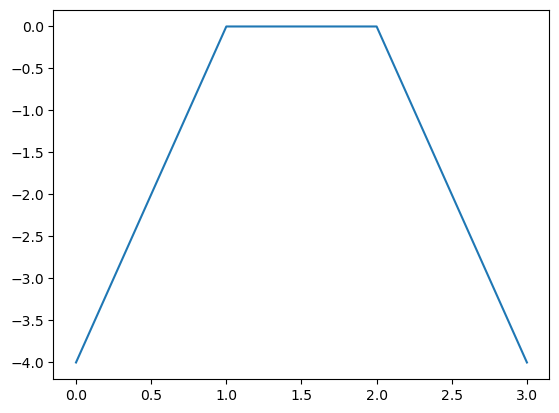

In [247]:
plt.plot(Array_dS_part3[1-1,500,:])

In [287]:
%%time
'''
Scrambled sets of contigs 
'''

### First strategy : 
#For each set R, I produce scrambled reads. First, I have to identify mutate position (A->C). Then, I move the 
#mutation in an other place of the genome. mn is unchanged, I can't mutate 2 time the same position


def prod_R_sets():
    new_dict = defaultdict()
    for n in reads:
        index = 0
        replace = list()
        already_mutate = list()
        base_positions = list()
        for nt in genome[reads[n][1]-1:reads[n][1]+reads[n][2]-1]:
            if nt != reads[n][3][index] and reads[n][0] != 0 :
                #string with genomic base and mutation to store in a list of strings
                replace.append(nt+reads[n][3][index])
            index += 1
        #print(replace)
        new_read = list(genome[reads[n][1]-1:reads[n][1]+reads[n][2]-1])

        #Take an element in replace, choose a random occurence of the base to mutate and mutate the base
        for base in replace:
            base_positions = [i for i in range(len(new_read)) if new_read[i] == base[0]] 
            base_positions = [x for x in base_positions if x not in already_mutate]      
            random_base_position = random.choice(base_positions)                         
            new_read[random_base_position] = base[1]
            already_mutate.append(random_base_position)
        new_dict[n] = [reads[n][0], reads[n][1], reads[n][2], ''.join(new_read)]
    return new_dict

tempo_var = Parallel(n_jobs=-1)(delayed(prod_R_sets)() for i in range(30))
reads_R1, reads_R2, reads_R3, reads_R4, reads_R5, reads_R6, reads_R7, reads_R8, reads_R9, reads_R10, reads_R11, reads_R12, reads_R13, reads_R14, reads_R15,reads_R16, reads_R17, reads_R18, reads_R19, reads_R20,reads_R21, reads_R22, reads_R23, reads_R24, reads_R25, reads_R26, reads_R27, reads_R28, reads_R29, reads_R30 = tempo_var

CPU times: user 112 ms, sys: 309 ms, total: 421 ms
Wall time: 1.82 s


In [288]:
%%time

'''
Calculate lambda for scrambled reads
'''

iteration          = 1
m_n                = tf.constant([mn for mn in mn_list], dtype=tf.float32) 
l_n                = tf.constant([ln for ln in ln_list], dtype=tf.float32)
logit_beta_n_init  = tf.Variable([float(reads[r][0])/float(reads[r][2]) for r in reads], dtype=tf.float32)
log_alpha_g_init   = tf.Variable([-10.0 for _ in range(len(orfs))], dtype=tf.float32)


#Only p2 DS have to be calculated here before to apply the GD in those R

@dask.delayed
def calc_ds_lambda_delayed(reads_dict):
    #global reads
    p2_list = []
    reads_R = reads_dict
    ##### Calculate deltaS for the part2 of the formula 
    Dict_dS2 = defaultdict(list)
    for nb in reads_R :
        for orf in orfs : #Forward ORFs
            second     = 0.0
            orf_start  = orfs[orf][0] #To avoid indexing each time
            orf_end    = orfs[orf][1]
            orf_strand = orfs[orf][2]
            read       = reads_R[nb][3]
            i_n        = reads_R[nb][1]
            l          = reads_R[nb][2]
            
            #Reads with ORF start inside
            if i_n <= orf_start <= i_n+l : 
                c_on_o = read[orf_start-i_n+1:orf_end-i_n] #Part of the read matching with the ORF
                n = len(c_on_o)%3
                if n in (1, 2) :
                    c_on_o = c_on_o[:-n]
                if orf_strand == '+' : #Forward ORF       
                    second = np.sum(calc_delta_S(c_on_o, orf_start, orf_start+len(c_on_o)))
                else: #Reverse ORF
                    second = np.sum(calc_delta_S_reverse(c_on_o, orf_start, orf_start+len(c_on_o)))
                    
            #Reads inside a large ORF
            elif (orf_start < i_n and orf_end > i_n+l) or (orf_end < i_n and orf_start > i_n+l): #forward ORF with the read inside
                c_on_o = read #The alignement is on the full read sequence in that case
                n = len(c_on_o)%3
                if n in (1, 2) :
                    c_on_o = c_on_o[:-n]
                if orf_strand == '+' : #Forward
                    second = np.sum(calc_delta_S(c_on_o, i_n-1, i_n+len(c_on_o)-1))
                else: #Reverse
                    second = np.sum(calc_delta_S_reverse(c_on_o, i_n-1, i_n+len(c_on_o)-1))
                    
            #Reads with ORF end inside but not ORF start
            elif i_n <= orf_end <= i_n+l : #ORf end is in the read but not the start
                c_on_o = read[:orf_end-i_n+1]
                n = len(c_on_o)%3
                if n in (1, 2) :
                    c_on_o = c_on_o[:-n]
                if orf_strand == '+' : #You're a forward ORF
                    second = np.sum(calc_delta_S(c_on_o, i_n-1, i_n+len(c_on_o)-1))        
                else :                 #You're a reverse ORF
                    second = np.sum(calc_delta_S_reverse(c_on_o, i_n-1, i_n+len(c_on_o)-1))
                    
            Dict_dS2[nb].append(second)
    #global Array_dS_part2_R
    Array_dS_part2_R = tf.constant(np.array(list(Dict_dS2.values())), dtype=tf.float32)
    Array_dS_part2_R = tf.convert_to_tensor(Array_dS_part2_R, dtype=float)
    ###

    lambda_gk = dict()
    A = list()
    
    
    for k in range(len(orfs)):
        logit_beta_n_R  = tf.Variable(logit_beta_n_init.initialized_value())   #This trick is to do a copy and not a miror copy
        log_alpha_g_R = tf.Variable(log_alpha_g_init.initialized_value())
        print(f'\nSTEP {k+1} :')
        opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)
        for i in range(iteration): 

            #Convert alpha_g to zero if g not in A at each steps of the optimization
            for i, val in enumerate(log_alpha_g_R):
                if not orf_values[i] in A:
                    log_alpha_g_R[i].assign(-10.0)  
            
            #print(f'Alpha before opt : {log_alpha_g_R}')
            with tf.GradientTape() as tape:
                tape.watch((log_alpha_g_R, logit_beta_n_R))
                loss = log_likelihood(log_alpha_g_R, logit_beta_n_R, reads_R, Array_dS_part2_R)
            gradients = tape.gradient(loss, [log_alpha_g_R, logit_beta_n_R])
            opt.apply_gradients(zip(gradients, [log_alpha_g_R, logit_beta_n_R]))
            #print(f'Alpha after opt : {log_alpha_g_R}') #alpha output is log_alpha so it's fine
            
        for i, val in enumerate(gradients[0]):
            if orf_values[i] in A:
                gradients[0] = tf.tensor_scatter_nd_update(gradients[0], tf.constant([[i]]), tf.constant([np.nan]))

        print(f'Gradient at the end of step {k+1} : {gradients[0]}')
        
        #Feed variables
        gk = orf_values[np.nanargmax(gradients[0])]
        A.append(gk)
        lambda_gk[gk] =  gradients[0][np.nanargmax(gradients[0])]
        print('gk :', gk, 'lambda', lambda_gk[gk].numpy())
        print("Active set at this step :", A)
    return lambda_gk
    

def calc_ds_lambda(reads_dict):
    #global reads
    p2_list = []
    reads_R = reads_dict
    ##### Calculate deltaS for the part2 of the formula 
    Dict_dS2 = defaultdict(list)
    for nb in reads_R :
        for orf in orfs : #Forward ORFs
            second     = 0.0
            orf_start  = orfs[orf][0] #To avoid indexing each time
            orf_end    = orfs[orf][1]
            orf_strand = orfs[orf][2]
            read       = reads_R[nb][3]
            i_n        = reads_R[nb][1]
            l          = reads_R[nb][2]
            
            #Reads with ORF start inside
            if i_n <= orf_start <= i_n+l : 
                c_on_o = read[orf_start-i_n+1:orf_end-i_n] #Part of the read matching with the ORF
                n = len(c_on_o)%3
                if n in (1, 2) :
                    c_on_o = c_on_o[:-n]
                if orf_strand == '+' : #Forward ORF       
                    second = np.sum(calc_delta_S(c_on_o, orf_start, orf_start+len(c_on_o)))
                else: #Reverse ORF
                    second = np.sum(calc_delta_S_reverse(c_on_o, orf_start, orf_start+len(c_on_o)))
                    
            #Reads inside a large ORF
            elif (orf_start < i_n and orf_end > i_n+l) or (orf_end < i_n and orf_start > i_n+l): #forward ORF with the read inside
                c_on_o = read #The alignement is on the full read sequence in that case
                n = len(c_on_o)%3
                if n in (1, 2) :
                    c_on_o = c_on_o[:-n]
                if orf_strand == '+' : #Forward
                    second = np.sum(calc_delta_S(c_on_o, i_n-1, i_n+len(c_on_o)-1))
                else: #Reverse
                    second = np.sum(calc_delta_S_reverse(c_on_o, i_n-1, i_n+len(c_on_o)-1))
                    
            #Reads with ORF end inside but not ORF start
            elif i_n <= orf_end <= i_n+l : #ORf end is in the read but not the start
                c_on_o = read[:orf_end-i_n+1]
                n = len(c_on_o)%3
                if n in (1, 2) :
                    c_on_o = c_on_o[:-n]
                if orf_strand == '+' : #You're a forward ORF
                    second = np.sum(calc_delta_S(c_on_o, i_n-1, i_n+len(c_on_o)-1))        
                else :                 #You're a reverse ORF
                    second = np.sum(calc_delta_S_reverse(c_on_o, i_n-1, i_n+len(c_on_o)-1))
                    
            Dict_dS2[nb].append(second)
    #global Array_dS_part2_R
    Array_dS_part2_R = tf.constant(np.array(list(Dict_dS2.values())), dtype=tf.float32)
    Array_dS_part2_R = tf.convert_to_tensor(Array_dS_part2_R, dtype=float)
    ###

    lambda_gk = dict()
    A = list()
    
    
    for k in range(len(orfs)):
        logit_beta_n_R  = tf.Variable(logit_beta_n_init.initialized_value())   #This trick is to do a copy and not a miror copy
        log_alpha_g_R = tf.Variable(log_alpha_g_init.initialized_value())
        print(f'\nSTEP {k+1} :')
        opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)
        for i in range(iteration): 

            #Convert alpha_g to zero if g not in A at each steps of the optimization
            for i, val in enumerate(log_alpha_g_R):
                if not orf_values[i] in A:
                    log_alpha_g_R[i].assign(-10.0)  
            
            #print(f'Alpha before opt : {log_alpha_g_R}')
            with tf.GradientTape() as tape:
                tape.watch((log_alpha_g_R, logit_beta_n_R))
                loss = log_likelihood(log_alpha_g_R, logit_beta_n_R, reads_R, Array_dS_part2_R)
            gradients = tape.gradient(loss, [log_alpha_g_R, logit_beta_n_R])
            opt.apply_gradients(zip(gradients, [log_alpha_g_R, logit_beta_n_R]))
            #print(f'Alpha after opt : {log_alpha_g_R}') #alpha output is log_alpha so it's fine
            
        for i, val in enumerate(gradients[0]):
            if orf_values[i] in A:
                gradients[0] = tf.tensor_scatter_nd_update(gradients[0], tf.constant([[i]]), tf.constant([np.nan]))

        print(f'Gradient at the end of step {k+1} : {gradients[0]}')
        
        #Feed variables
        gk = orf_values[np.nanargmax(gradients[0])]
        A.append(gk)
        lambda_gk[gk] =  gradients[0][np.nanargmax(gradients[0])]
        print('gk :', gk, 'lambda', lambda_gk[gk].numpy())
        print("Active set at this step :", A)
    return lambda_gk
    

'''    
R = [reads_R1, reads_R2, reads_R3, reads_R4, reads_R5, 
     reads_R6, reads_R7, reads_R8, reads_R9, reads_R10, 
     reads_R11, reads_R12, reads_R13, reads_R14, reads_R15,
     reads_R16, reads_R17, reads_R18, reads_R19, reads_R20,
     reads_R21, reads_R22, reads_R23, reads_R24, reads_R25,
     reads_R26, reads_R27, reads_R28, reads_R29, reads_R30]
'''
R = [reads_R1, reads_R2, reads_R3, reads_R4, reads_R5, 
     reads_R6, reads_R7, reads_R8, reads_R9, reads_R10, 
     reads_R11, reads_R12, reads_R13, reads_R14, reads_R15]



#Lambdas for scrambled reads (adapt values in R)
#R = [reads_R1, reads_R2, reads_R3]
results = []
for v in R : 
    results.append(calc_ds_lambda_delayed(v))
b = dask.compute(results)

#Lambdas for initial reads sets
#lambda_R = calc_ds_lambda(reads)
results2 = []
results2.append(calc_ds_lambda_delayed(reads))
lambda_R = dask.compute(results2)



STEP 1 :

STEP 1 :

STEP 1 :

STEP 1 :

STEP 1 :

STEP 1 :

STEP 1 :

STEP 1 :
p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.22, shape=(), dtype=float32) -p_all tf.Tensor(71676.22, shape=(), dtype=float32)
p_all tf.Tensor(-71676.22, shape=(), dtype=float32) -p_all tf.Tensor(71676.22, shape=(), dtype=float32)
p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.22, shape=(), dtype=float32) -p_all tf.Tensor(71676.22, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
Gradient at the end of step 1 : [7.226029   0.03651135 0.13009685 0.10760381 0.04858736 

Gradient at the end of step 2 : [       nan 0.03528555 0.13018765 0.10755841 0.04740697 0.309274
 0.09903374 0.12342811 0.63669324 0.6050273  0.7229407  0.03113043
 1.090497   0.1313244  0.40593857 0.13600445 0.22846824 0.05994536
 0.26816157 4.3512216  0.45226347 0.71343505 0.5033388  0.11841016
 0.06739669 0.71517164 0.5863361  0.43396717 0.26961115 0.21282876
 0.03883047 1.723069   0.50505334]
gk : rooOCeanUs1_ORF.20 lambda 4.3512216
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20']

STEP 3 :
Gradient at the end of step 2 : [       nan 0.03651135 0.12986985 0.10724061 0.04767936 0.3102274
 0.09903374 0.12547112 0.6344687  0.6028481  0.7243935  0.03035863
 1.0907694  0.13196    0.40521216 0.13382526 0.22964863 0.05999076
 0.26825237 4.3475895  0.45044747 0.71284485 0.5040652  0.11854636
 0.06739669 0.71394587 0.58588207 0.43228737 0.26970196 0.21314655
 0.03883047 1.7211621  0.50900316]
gk : rooOCeanUs1_ORF.20 lambda 4.3475895
Active set at this step : ['rooOCeanU

Gradient at the end of step 4 : [       nan 0.03528555 0.13018765 0.10755841 0.04740697 0.309274
 0.09903374 0.12342811 0.63669324 0.6050273  0.7229407  0.03113043
 1.090497   0.1313244  0.40593857 0.13600445 0.22846824 0.05994536
 0.26816157        nan 0.45226347 0.71343505 0.5033388  0.11841016
 0.06739669 0.71517164 0.5863361  0.43396717 0.26961115 0.21282876
 0.03883047        nan 0.50505334]
gk : rooOCeanUs1_ORF.13 lambda 1.090497
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13']

STEP 5 :
Gradient at the end of step 4 : [       nan 0.03651135 0.13009685 0.10760381 0.04858736 0.3090924
 0.09885214 0.12397292 0.63601226 0.6025303  0.7251199  0.02895123
 1.0917228  0.13250479 0.40589315 0.13559584 0.22887683 0.05940055
 0.26916036        nan 0.4506291  0.71252704 0.5036566  0.11836476
 0.0670789  0.71362805 0.5864723  0.43287757 0.27038294 0.21237476
 0.03883047        nan 0.50873077]
gk : rooOCeanUs1_ORF.13 lambda 1.09

p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.22, shape=(), dtype=float32) -p_all tf.Tensor(71676.22, shape=(), dtype=float32)
p_all tf.Tensor(-71676.22, shape=(), dtype=float32) -p_all tf.Tensor(71676.22, shape=(), dtype=float32)
p_all tf.Tensor(-71676.22, shape=(), dtype=float32) -p_all tf.Tensor(71676.22, shape=(), dtype=float32)
Gradient at the end of step 6 : [       nan 0.03669294 0.13000605 0.10737681 0.04731617 0.3093194
 0.09867054 0.12388211 0.6330159  0.60666174        nan 0.03044943
   


STEP 8 :
Gradient at the end of step 7 : [       nan 0.03651135 0.13036925 0.10774001 0.04799717 0.30904698
 0.09867054 0.12360971 0.63006485 0.60552675        nan 0.02945063
        nan 0.1320962  0.40385017 0.13573205 0.22805963 0.05912816
 0.26825237        nan 0.45040208        nan 0.5042014  0.11854636
 0.06739669 0.7132648  0.5854735  0.43169716 0.27051914 0.21378216
 0.03883047        nan 0.5085946 ]
gk : rooOCeanUs1_ORF.26 lambda 0.7132648
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.26']

STEP 8 :
Gradient at the end of step 7 : [       nan 0.03651135 0.13009685 0.10760381 0.04858736 0.3090924
 0.09885214 0.12397292 0.63601226 0.6025303         nan 0.02895123
        nan 0.13250479 0.40589315 0.13559584 0.22887683 0.05940055
 0.26916036        nan 0.4506291  0.71252704 0.5036566  0.11836476
 0.0670789         nan 0.5864723  0.43287757 0.27038294 0.

Gradient at the end of step 8 : [       nan 0.03555795 0.13036925 0.10728601 0.04817877 0.3089108
 0.09848894 0.1250171  0.63415086 0.6048457         nan 0.02985923
        nan 0.1325502  0.40325996 0.13459705 0.22810504 0.05962756
 0.26979595        nan 0.45026588        nan 0.50388366 0.11859176
 0.0673513         nan 0.58556426 0.43560156 0.27065533 0.21341896
 0.03883047        nan 0.50723255]
gk : rooOCeanUs1_ORF.9 lambda 0.63415086
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9']

STEP 9 :
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.22, shape=(), dtype=float32) -p_all tf.Tensor(71676.22, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=()

Gradient at the end of step 10 : [       nan 0.03669294 0.13000605 0.10737681 0.04731617 0.3093194
 0.09867054 0.12388211        nan        nan        nan 0.03044943
        nan 0.13232319 0.40439495 0.13314426 0.22851364 0.05967296
 0.26979595        nan 0.45126468        nan 0.50447387 0.11713896
 0.0671243         nan 0.58642685 0.43319538 0.27101853 0.21341896
 0.03883047        nan 0.50863993]
gk : rooOCeanUs1_ORF.27 lambda 0.58642685
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27']

STEP 11 :
Gradient at the end of step 10 : [       nan 0.03651135 0.12986985 0.10724061 0.04767936 0.3102274
 0.09903374 0.12547112        nan        nan        nan 0.03035863
        nan 0.13196    0.40521216 0.13382526 0.22964863 0.05999076
 0.26825237        nan 0.45044747        nan 0.5040652  0.11854636


Gradient at the end of step 11 : [       nan 0.03651135 0.13036925 0.10774001 0.04799717 0.30904698
 0.09867054 0.12360971        nan        nan        nan 0.02945063
        nan 0.1320962  0.40385017 0.13573205 0.22805963 0.05912816
 0.26825237        nan 0.45040208        nan 0.5042014  0.11854636
 0.06739669        nan        nan 0.43169716 0.27051914 0.21378216
 0.03883047        nan 0.5085946 ]
gk : rooOCeanUs1_ORF.33 lambda 0.5085946
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33']

STEP 12 :
Gradient at the end of step 11 : [       nan 0.03528555 0.12959746 0.10742221 0.04881436 0.3080028
 0.09903374 0.12156672        nan        nan        nan 0.02840643
        nan 0.13268639 0.40221578 0.13514185 0.22933084 0.05953676
 0.26920575        nan 0.44949406        nan 

Gradient at the end of step 12 : [       nan 0.03555795 0.13036925 0.10728601 0.04817877 0.3089108
 0.09848894 0.1250171         nan        nan        nan 0.02985923
        nan 0.1325502  0.40325996 0.13459705 0.22810504 0.05962756
 0.26979595        nan 0.45026588        nan 0.50388366 0.11859176
 0.0673513         nan        nan 0.43560156 0.27065533 0.21341896
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.23 lambda 0.50388366
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23']

STEP 13 :
p_all tf.Tensor(-71676.22, shape=(), dtype=float32) -p_all tf.Tensor(71676.22, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float

p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.22, shape=(), dtype=float32) -p_all tf.Tensor(71676.22, shape=(), dtype=float32)
p_all tf.Tensor(-71676.22, shape=(), dtype=float32) -p_all tf.Tensor(71676.22, shape=(), dtype=float32)
Gradient at the end of step 14 : [       nan 0.03528555 0.13018765 0.10755841 0.04740697 0.309274
 0.09903374 0.12342811        nan        nan        nan 0.03113043
        nan 0.1313244  0.40593857 0.13600445 0.22846824 0.05994536
 0.26816157        nan        nan        nan        nan 0.11841016
 0.06739669        nan        nan 0.43396717 0.26961115 0.21282876
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.28 lambda 0.43396717
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 

Gradient at the end of step 15 : [       nan 0.03651135 0.12986985 0.10724061 0.04767936 0.3102274
 0.09903374 0.12547112        nan        nan        nan 0.03035863
        nan 0.13196    0.40521216 0.13382526 0.22964863 0.05999076
 0.26825237        nan        nan        nan        nan 0.11854636
 0.06739669        nan        nan        nan 0.26970196 0.21314655
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.15 lambda 0.40521216
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15']

STEP 16 :
Gradient at the end of step 15 : [       nan 0.03669294 0.13000605 0.10737681 0.04731617 0.3093194
 0.09867054 0.12388211        nan        nan        nan 0.03044943
        nan 0.13232319 0

Gradient at the end of step 16 : [       nan 0.03651135 0.13009685 0.10760381 0.04858736 0.3090924
 0.09885214 0.12397292        nan        nan        nan 0.02895123
        nan 0.13250479        nan 0.13559584 0.22887683 0.05940055
 0.26916036        nan        nan        nan        nan 0.11836476
 0.0670789         nan        nan        nan 0.27038294 0.21237476
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.6 lambda 0.3090924
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6']

STEP 17 :
Gradient at the end of step 16 : [       nan 0.03537635 0.13036925 0.10733141 0.04740697 0.3105906
 0.09903374 0.12601592        nan        nan        nan 0.02976843
     

Gradient at the end of step 17 : [       nan 0.03537635 0.13036925 0.10733141 0.04740697        nan
 0.09903374 0.12601592        nan        nan        nan 0.02976843
        nan 0.1313244         nan 0.13614064 0.22942163 0.05890116
 0.26934198        nan        nan        nan        nan 0.11827396
 0.06739669        nan        nan        nan 0.26942953 0.21287416
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.29 lambda 0.26942953
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29']

STEP 18 :
Gradient at the end of step 17 : [       nan 0.03651135 0.13036925 0.10774001 0.04799717        nan
 0.09867054 0.12360971        nan        nan  

Gradient at the end of step 18 : [       nan 0.03528555 0.12959746 0.10742221 0.04881436        nan
 0.09903374 0.12156672        nan        nan        nan 0.02840643
        nan 0.13268639        nan 0.13514185 0.22933084 0.05953676
 0.26920575        nan        nan        nan        nan 0.11841016
 0.0671243         nan        nan        nan        nan 0.21296495
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.19 lambda 0.26920575
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19']

STEP 19 :
Gradient at the end of step 18 : [       nan 0.03651135 0.13036925 0.10774001 0.04799717        nan
 0.09867054 0.12360971  

p_all tf.Tensor(-71676.22, shape=(), dtype=float32) -p_all tf.Tensor(71676.22, shape=(), dtype=float32)
Gradient at the end of step 19 : [       nan 0.03651135 0.13036925 0.10774001 0.04799717        nan
 0.09867054 0.12360971        nan        nan        nan 0.02945063
        nan 0.1320962         nan 0.13573205 0.22805963 0.05912816
        nan        nan        nan        nan        nan 0.11854636
 0.06739669        nan        nan        nan        nan 0.21378216
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.17 lambda 0.22805963
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17']

STEP 20 

Gradient at the end of step 20 : [       nan 0.03555795 0.13036925 0.10728601 0.04817877        nan
 0.09848894 0.1250171         nan        nan        nan 0.02985923
        nan 0.1325502         nan 0.13459705        nan 0.05962756
        nan        nan        nan        nan        nan 0.11859176
 0.0673513         nan        nan        nan        nan 0.21341896
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.30 lambda 0.21341896
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.30']

STEP 21 :
Gradient at the end of step 20 : [       nan 0.03651135 0.13036925 0.10774001 0.

Gradient at the end of step 21 : [       nan 0.03555795 0.13036925 0.10728601 0.04817877        nan
 0.09848894 0.1250171         nan        nan        nan 0.02985923
        nan 0.1325502         nan 0.13459705        nan 0.05962756
        nan        nan        nan        nan        nan 0.11859176
 0.0673513         nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.16 lambda 0.13459705
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.16']

STEP 22 :
Gradient at the end of step 21 : [       nan 0.03651135 0.

Gradient at the end of step 22 : [       nan 0.03555795 0.13036925 0.10728601 0.04817877        nan
 0.09848894 0.1250171         nan        nan        nan 0.02985923
        nan 0.1325502         nan        nan        nan 0.05962756
        nan        nan        nan        nan        nan 0.11859176
 0.0673513         nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.14 lambda 0.1325502
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.14']

STEP 23 :
Gradient at the end of step 22 : [   

Gradient at the end of step 23 : [       nan 0.03528555 0.12959746 0.10742221 0.04881436        nan
 0.09903374 0.12156672        nan        nan        nan 0.02840643
        nan        nan        nan        nan        nan 0.05953676
        nan        nan        nan        nan        nan 0.11841016
 0.0671243         nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.3 lambda 0.12959746
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.14', 'rooOCeanUs1_ORF.3']

STEP 24 :
Gradient at the 

Gradient at the end of step 24 : [       nan 0.03528555        nan 0.10742221 0.04881436        nan
 0.09903374 0.12156672        nan        nan        nan 0.02840643
        nan        nan        nan        nan        nan 0.05953676
        nan        nan        nan        nan        nan 0.11841016
 0.0671243         nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.8 lambda 0.12156672
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.14', 'rooOCeanUs1_ORF.3', 'rooOCeanUs1_ORF.8']

STEP 

Gradient at the end of step 25 : [       nan 0.03528555        nan 0.10742221 0.04881436        nan
 0.09903374        nan        nan        nan        nan 0.02840643
        nan        nan        nan        nan        nan 0.05953676
        nan        nan        nan        nan        nan 0.11841016
 0.0671243         nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.24 lambda 0.118410155
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.14', 'rooOCeanUs1_ORF.3', 'rooOCeanUs1_ORF.8', 'roo

Gradient at the end of step 26 : [       nan 0.03528555        nan 0.10742221 0.04881436        nan
 0.09903374        nan        nan        nan        nan 0.02840643
        nan        nan        nan        nan        nan 0.05953676
        nan        nan        nan        nan        nan        nan
 0.0671243         nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.4 lambda 0.10742221
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.14', 'rooOCeanUs1_ORF.3', 'rooOCeanUs1_ORF.8', 'rooOC

Gradient at the end of step 27 : [       nan 0.03555795        nan        nan 0.04817877        nan
 0.09848894        nan        nan        nan        nan 0.02985923
        nan        nan        nan        nan        nan 0.05962756
        nan        nan        nan        nan        nan        nan
 0.0673513         nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.7 lambda 0.09848894
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.14', 'rooOCeanUs1_ORF.3', 'rooOCeanUs1_ORF.8', 'rooOC

Gradient at the end of step 28 : [       nan 0.03555795        nan        nan 0.04817877        nan
        nan        nan        nan        nan        nan 0.02985923
        nan        nan        nan        nan        nan 0.05962756
        nan        nan        nan        nan        nan        nan
 0.0673513         nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.25 lambda 0.0673513
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.14', 'rooOCeanUs1_ORF.3', 'rooOCeanUs1_ORF.8', 'rooOC

Gradient at the end of step 29 : [       nan 0.03651135        nan        nan 0.04858736        nan
        nan        nan        nan        nan        nan 0.02895123
        nan        nan        nan        nan        nan 0.05940055
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.18 lambda 0.059400555
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.14', 'rooOCeanUs1_ORF.3', 'rooOCeanUs1_ORF.8', 'roo

Gradient at the end of step 30 : [       nan 0.03651135        nan        nan 0.04767936        nan
        nan        nan        nan        nan        nan 0.03035863
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.5 lambda 0.047679365
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.14', 'rooOCeanUs1_ORF.3', 'rooOCeanUs1_ORF.8', 'rooO

p_all tf.Tensor(-71676.22, shape=(), dtype=float32) -p_all tf.Tensor(71676.22, shape=(), dtype=float32)
Gradient at the end of step 31 : [       nan 0.03669294        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.03044943
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.31 lambda 0.038830474
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCea

p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.22, shape=(), dtype=float32) -p_all tf.Tensor(71676.22, shape=(), dtype=float32)
p_all tf.Tensor(-71676.22, shape=(), dtype=float32) -p_all tf.Tensor(71676.22, shape=(), dtype=float32)
p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
Gradient at the end of step 32 : [       nan 0.03528555        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.03113043
        nan        nan        nan        nan        nan        nan
        nan        nan        nan     

Gradient at the end of step 32 : [       nan 0.03651135        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.02945063
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]
gk : rooOCeanUs1_ORF.2 lambda 0.036511347
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.14', 'rooOCeanUs1_ORF.3', 'rooOCeanUs1_ORF.8', 'rooO


STEP 1 :
Gradient at the end of step 33 : [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.02840643
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]
gk : rooOCeanUs1_ORF.12 lambda 0.02840643
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.14', 'rooOCeanUs1_ORF.3', 'rooOCeanUs1_ORF

Gradient at the end of step 2 : [       nan 0.03669294 0.13036925 0.10810321 0.04845116 0.3080028
 0.09903374 0.12515332 0.63337904 0.6071611  0.7238941  0.02727143
 1.0910418  0.1317784  0.40480357 0.13609526 0.22914924 0.06003616
 0.26788917 4.3466363  0.44867688 0.71252704 0.50456464 0.11863716
 0.06739669 0.7147176  0.5823409  0.43301377 0.27092776 0.21278335
 0.03883047 1.7179841  0.50791353]
gk : rooOCeanUs1_ORF.20 lambda 4.3466363
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20']

STEP 3 :
Gradient at the end of step 2 : [       nan 0.03651135 0.13014226 0.10769461 0.04767936 0.3096372
 0.09903374 0.12442691 0.6349226  0.60566294 0.7226683  0.02699903
 1.0900431  0.13127899 0.40430418 0.13500565 0.22964863 0.05999076
 0.26761678 4.347771   0.45022047 0.7133442  0.50361127 0.11854636
 0.0669881  0.71476305 0.59019506 0.43369478 0.27047375 0.21400915
 0.03883047 1.7233866  0.50800437]
gk : rooOCeanUs1_ORF.20 lambda 4.347771
Active set at this step : ['rooOCeanU

p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
Gradient at the end of step 4 : [       nan 0.03669294 0.13014226 0.10724061 0.04763396 0.309274
 0.09867054 0.12356431 0.6343324  0.60439175 0.7256193  0.03099423
 1.0915412  0.131052   0.40339616 0.13527805 0.22964863 0.06021775
 0.26584616        nan 0.45071986 0.71438843 0.50501865 0.11809236
 0.0665795  0.7142636  0.5870625  0.43160638 0.27006516 0.21409996
 0.03883047        nan 0.50873077]
gk : rooOCeanUs1_ORF.13 lambda 1.0915412
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13']

STEP 5 :
Gradient at the end of step 4 : [       nan 0.03669294 0.13036925 0.10810321 0.04845116 0.3080028
 0.09903374 0.12515332 0.63337904 0.6071611  0.7238941  0.02727143
 1.0910418  0.1317784  0.40480357 0.13609526 0.22914924 0.06003616
 0.26788917        nan 0.44867688 0.71252704 0.50456464 0.11863716
 0.06739669 0.7147176  0.5823409

p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
Gradient at the end of step 6 : [       nan 0.03555795 0.13005145 0.10778541 0.04804257 0.30990958
 0.09848894 0.12315571 0.63415086 0.6060261         nan 0.02718063
        nan 0.13268639 0.40244275 0.13473324 0.22842284 0.05871956
 0.26902416        nan 0.45199108 0.71211845 0.5046554  0.11800156
 0.0672151  0.71321946 0.5866539  0.43296838 0.27024674 0.21364595
 0.038830

Gradient at the end of step 7 : [       nan 0.03651135 0.13014226 0.10769461 0.04767936 0.3096372
 0.09903374 0.12442691 0.6349226  0.60566294        nan 0.02699903
        nan 0.13127899 0.40430418 0.13500565 0.22964863 0.05999076
 0.26761678        nan 0.45022047 0.7133442  0.50361127 0.11854636
 0.0669881         nan 0.59019506 0.43369478 0.27047375 0.21400915
 0.03883047        nan 0.50800437]
gk : rooOCeanUs1_ORF.22 lambda 0.7133442
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22']

STEP 8 :
Gradient at the end of step 7 : [       nan 0.03669294 0.13014226 0.10764921 0.04731617 0.3082752
 0.09844355 0.12292872 0.6363754  0.60434633        nan 0.03140283
        nan 0.1320508  0.40498516 0.13459705 0.22874063 0.05871956
 0.26925117        nan 0.44726947 0.7137982  0.50447387 0.11709356
 0.06739669        nan 0.5879705  0.43405798 0.27011055 0.21287416
 0

p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
Gradient at the end of step 9 : [       nan 0.03669294 0.13014226 0.10724061 0.04763396 0.309274
 0.09867054 0.12356431        nan 0.60439175        nan 0.03099423
        nan 0.131052   0.40339616 0.13527805 0.22964863 0.06021775
 0.26584616        nan 0.45071986        nan 0.50501865 0.11809236
 0.0665795         nan 0.5870625  0.43160638 0.27006516 0.21409996
 0.03883047        nan 0.50873077]
gk : rooOCeanUs1_ORF.10 lambda 0.60439175
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10']

STEP 10 :
Gradient at the end of step 9 : [       nan 0.03669294 0.13036925 0.10810321 0.04845116 0.3080028
 0.09903374 0.12515332        nan 0.6071611         nan 0.02727143
        nan 0.1317784  0.40480357 0.13609526 0.22914924

Gradient at the end of step 10 : [       nan 0.03669294 0.13014226 0.10764921 0.04731617 0.3082752
 0.09844355 0.12292872        nan        nan        nan 0.03140283
        nan 0.1320508  0.40498516 0.13459705 0.22874063 0.05871956
 0.26925117        nan 0.44726947        nan 0.50447387 0.11709356
 0.06739669        nan 0.5879705  0.43405798 0.27011055 0.21287416
 0.03883047        nan 0.50850374]
gk : rooOCeanUs1_ORF.27 lambda 0.5879705
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27']

STEP 11 :
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtyp

Gradient at the end of step 12 : [       nan 0.03669294 0.13014226 0.10755841 0.04808797 0.3090016
 0.09885214 0.12451771        nan        nan        nan 0.03054023
        nan 0.1320962  0.40512136 0.13523266 0.22860444 0.06030855
 0.26879716        nan 0.45035666        nan 0.50388366 0.11854636
 0.0670789         nan        nan 0.43360397 0.27074614 0.21437235
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.23 lambda 0.50388366
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23']

STEP 13 :
Gradient at the end of step 12 : [       nan 0.03642055 0.13000605 0.10769461 0.04618117 0.3076396
 0.09903374 0.12383671        nan        nan        nan 0.02976843
        nan 0.132414   0.40348697 0.13595904 0.22978483 0.06035395
 0.26766217        nan 

Gradient at the end of step 13 : [       nan 0.03669294 0.13036925 0.10810321 0.04845116 0.3080028
 0.09903374 0.12515332        nan        nan        nan 0.02727143
        nan 0.1317784  0.40480357 0.13609526 0.22914924 0.06003616
 0.26788917        nan 0.44867688        nan        nan 0.11863716
 0.06739669        nan        nan 0.43301377 0.27092776 0.21278335
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.21 lambda 0.44867688
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21']

STEP 14 :
Gradient at the end of step 13 : [       nan 0.03669294 0.13014226 0.10764921 0.04731617 0.3082752
 0.09844355 0.12292872        nan        nan        nan 0.03140283
        nan 0.1320508  0.40498516 0.13459705 0.22874063 0.05871956
 

p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
Gradient at the end of step 15 : [       nan 0.03555795 0.13005145 0.10778541 0.04804257 0.30990958
 0.09848894 0.12315571        nan        nan        nan 0.02718063
        nan 0.13268639 0.40244275 0.13473324 0.22842284 0.05871956
 0.26902416        nan        nan        nan        nan 0.11800156
 0.0672151         nan        nan        nan 0.27024674 0.21364595
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.15 lambda 0.40244275
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15']

STEP 16 :
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=

Gradient at the end of step 16 : [       nan 0.03651135 0.13014226 0.10769461 0.04767936 0.3096372
 0.09903374 0.12442691        nan        nan        nan 0.02699903
        nan 0.13127899        nan 0.13500565 0.22964863 0.05999076
 0.26761678        nan        nan        nan        nan 0.11854636
 0.0669881         nan        nan        nan 0.27047375 0.21400915
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.6 lambda 0.3096372
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6']

STEP 17 :
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
Gradient at the end of step 16 : [       nan 0.03669294 0.13014226 

Gradient at the end of step 17 : [       nan 0.03669294 0.13036925 0.10810321 0.04845116        nan
 0.09903374 0.12515332        nan        nan        nan 0.02727143
        nan 0.1317784         nan 0.13609526 0.22914924 0.06003616
 0.26788917        nan        nan        nan        nan 0.11863716
 0.06739669        nan        nan        nan 0.27092776 0.21278335
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.29 lambda 0.27092776
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29']

STEP 18 :
Gradient at the end of step 17 : [       nan 0.03669294 0.13014226 0.10755841 0.04808797        nan
 0.09885214 0.12451771        nan        nan  

Gradient at the end of step 18 : [       nan 0.03642055 0.13000605 0.10769461 0.04618117        nan
 0.09903374 0.12383671        nan        nan        nan 0.02976843
        nan 0.132414          nan 0.13595904 0.22978483 0.06035395
 0.26766217        nan        nan        nan        nan 0.11859176
 0.06739669        nan        nan        nan        nan 0.21278335
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.19 lambda 0.26766217
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19']

STEP 19 :
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-716

p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
Gradient at the end of step 20 : [       nan 0.03555795 0.13005145 0.10778541 0.04804257        nan
 0.09848894 0.12315571        nan        nan        nan 0.02718063
        nan 0.13268639        nan 0.13473324        nan 0.05871956
        nan        nan        nan        nan        nan 0.11800156
 0.0672151         nan        nan        nan        nan 0.21364595
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.30 lambda 0.21364595
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_O

p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
Gradient at the end of step 21 : [       nan 0.03669294 0.13014226 0.10724061 0.04763396        nan
 0.09867054 0.12356431        nan        nan        nan 0.03099423
        nan 0.131052          nan 0.13527805        nan 0.06021775
        nan        nan        nan        nan        nan 0.11809236
 0.0665795         nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.16 lambda 0.13527805
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCean

Gradient at the end of step 22 : [       nan 0.03651135 0.13014226 0.10769461 0.04767936        nan
 0.09903374 0.12442691        nan        nan        nan 0.02699903
        nan 0.13127899        nan        nan        nan 0.05999076
        nan        nan        nan        nan        nan 0.11854636
 0.0669881         nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.14 lambda 0.13127899
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.14']

STEP 23 :
Gradient at the end of step 22 : [  


STEP 24 :
Gradient at the end of step 23 : [       nan 0.03669294 0.13036925 0.10810321 0.04845116        nan
 0.09903374 0.12515332        nan        nan        nan 0.02727143
        nan        nan        nan        nan        nan 0.06003616
        nan        nan        nan        nan        nan 0.11863716
 0.06739669        nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.3 lambda 0.13036925
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.14', 'rooOCeanUs1_ORF.3']

STEP 24 :
Gradi

Gradient at the end of step 24 : [       nan 0.03651135        nan 0.10769461 0.04767936        nan
 0.09903374 0.12442691        nan        nan        nan 0.02699903
        nan        nan        nan        nan        nan 0.05999076
        nan        nan        nan        nan        nan 0.11854636
 0.0669881         nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.8 lambda 0.12442691
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.14', 'rooOCeanUs1_ORF.3', 'rooOCeanUs1_ORF.8']

STEP 

Gradient at the end of step 25 : [       nan 0.03642055        nan 0.10769461 0.04618117        nan
 0.09903374        nan        nan        nan        nan 0.02976843
        nan        nan        nan        nan        nan 0.06035395
        nan        nan        nan        nan        nan 0.11859176
 0.06739669        nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.24 lambda 0.118591756
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.14', 'rooOCeanUs1_ORF.3', 'rooOCeanUs1_ORF.8', 'roo

p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
Gradient at the end of step 27 : [       nan 0.03555795        nan        nan 0.04804257        nan
 0.09848894        nan        nan        nan        nan 0.02718063
        nan        nan        nan        nan        nan 0.05871956
        nan        nan        nan        nan        nan        nan
 0.0672151         nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.7 lambda 0.09848894
Active set at this step : ['rooOCean

p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
Gradient at the end of step 28 : [       nan 0.03555795        nan        nan 0.04804257        nan
        nan        nan        nan        nan        nan 0.02718063
        nan        nan        nan        nan        nan 0.05871956
        nan        nan        nan        nan        nan        nan
 0.0672151         nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.25 lambda 0.0672151
Active set at this step : ['rooOCean

p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
Gradient at the end of step 29 : [       nan 0.03555795        nan        nan 0.04804257        nan
        nan        nan        nan        nan        nan 0.02718063
        nan        nan        nan        nan        nan 0.05871956
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.18 lambda 0.058719557
Active set at this step : ['rooOCe

p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
Gradient at the end of step 30 : [       nan 0.03555795        nan        nan 0.04804257        nan
        nan        nan        nan        nan        nan 0.02718063
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.5 lambda 0.048042566
Active set at this step : ['rooOCea

p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
Gradient at the end of step 31 : [       nan 0.03555795        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.02718063
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.31 lambda 0.038830474
Active set at this step : ['rooOCe

p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
Gradient at the end of step 32 : [       nan 0.03555795        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.02718063
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]
gk : rooOCeanUs1_ORF.2 lambda 0.035557948
Active set at this step : ['rooOCea

p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.23, shape=(), dtype=float32) -p_all tf.Tensor(71676.23, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
p_all tf.Tensor(-71676.21, shape=(), dtype=float32) -p_all tf.Tensor(71676.21, shape=(), dtype=float32)
Gradient at the end of step 33 : [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.02718063
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]
gk : rooOCeanUs1_ORF.12 lambda 0.02718063
Active set at this step : ['rooOCea


STEP 1 :
p_all tf.Tensor(-71676.1, shape=(), dtype=float32) -p_all tf.Tensor(71676.1, shape=(), dtype=float32)
Gradient at the end of step 1 : [7.290497   0.03428675 0.12982444 0.10783081 0.04763396 0.3075942
 0.09903374 0.12315571 0.63682944 0.6054359  0.7294783  0.03199302
 1.0919498  0.13023481 0.40907115 0.13491485 0.22964863 0.05899196
 0.26925117 4.390402   0.45031127 0.7130718  0.50243086 0.11818316
 0.0670335  0.714536   0.59073985 0.43578318 0.27047375 0.21187536
 0.03883047 1.7291979  0.5100473 ]
gk : rooOCeanUs1_ORF.1 lambda 7.290497
Active set at this step : ['rooOCeanUs1_ORF.1']

STEP 2 :
p_all tf.Tensor(-71676.1, shape=(), dtype=float32) -p_all tf.Tensor(71676.1, shape=(), dtype=float32)
Gradient at the end of step 2 : [       nan 0.03428675 0.12982444 0.10783081 0.04763396 0.3075942
 0.09903374 0.12315571 0.63682944 0.6054359  0.7294783  0.03199302
 1.0919498  0.13023481 0.40907115 0.13491485 0.22964863 0.05899196
 0.26925117 4.390402   0.45031127 0.7130718  0.50243086 

p_all tf.Tensor(-71676.1, shape=(), dtype=float32) -p_all tf.Tensor(71676.1, shape=(), dtype=float32)
Gradient at the end of step 13 : [       nan 0.03428675 0.12982444 0.10783081 0.04763396 0.3075942
 0.09903374 0.12315571        nan        nan        nan 0.03199302
        nan 0.13023481 0.40907115 0.13491485 0.22964863 0.05899196
 0.26925117        nan 0.45031127        nan        nan 0.11818316
 0.0670335         nan        nan 0.43578318 0.27047375 0.21187536
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.21 lambda 0.45031127
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21']

STEP 14 :
p_all tf.Tensor(-71676.1, shape=(), dtype=float32) -p_all tf.Tensor(71676.1, shape=(), dtype=float32)
Gradient at the end of step 14

p_all tf.Tensor(-71676.1, shape=(), dtype=float32) -p_all tf.Tensor(71676.1, shape=(), dtype=float32)
Gradient at the end of step 22 : [       nan 0.03428675 0.12982444 0.10783081 0.04763396        nan
 0.09903374 0.12315571        nan        nan        nan 0.03199302
        nan 0.13023481        nan        nan        nan 0.05899196
        nan        nan        nan        nan        nan 0.11818316
 0.0670335         nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.14 lambda 0.13023481
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCeanUs

p_all tf.Tensor(-71676.1, shape=(), dtype=float32) -p_all tf.Tensor(71676.1, shape=(), dtype=float32)
Gradient at the end of step 30 : [       nan 0.03428675        nan        nan 0.04763396        nan
        nan        nan        nan        nan        nan 0.03199302
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.03883047        nan        nan]
gk : rooOCeanUs1_ORF.5 lambda 0.047633965
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.17', 'rooOCeanUs

In [291]:
lambda_R

([{'rooOCeanUs1_ORF.1': <tf.Tensor: shape=(), dtype=float32, numpy=7.290497>,
   'rooOCeanUs1_ORF.20': <tf.Tensor: shape=(), dtype=float32, numpy=4.390402>,
   'rooOCeanUs1_ORF.32': <tf.Tensor: shape=(), dtype=float32, numpy=1.7291979>,
   'rooOCeanUs1_ORF.13': <tf.Tensor: shape=(), dtype=float32, numpy=1.0919498>,
   'rooOCeanUs1_ORF.11': <tf.Tensor: shape=(), dtype=float32, numpy=0.7294783>,
   'rooOCeanUs1_ORF.26': <tf.Tensor: shape=(), dtype=float32, numpy=0.714536>,
   'rooOCeanUs1_ORF.22': <tf.Tensor: shape=(), dtype=float32, numpy=0.7130718>,
   'rooOCeanUs1_ORF.9': <tf.Tensor: shape=(), dtype=float32, numpy=0.63682944>,
   'rooOCeanUs1_ORF.10': <tf.Tensor: shape=(), dtype=float32, numpy=0.6054359>,
   'rooOCeanUs1_ORF.27': <tf.Tensor: shape=(), dtype=float32, numpy=0.59073985>,
   'rooOCeanUs1_ORF.33': <tf.Tensor: shape=(), dtype=float32, numpy=0.5100473>,
   'rooOCeanUs1_ORF.23': <tf.Tensor: shape=(), dtype=float32, numpy=0.50243086>,
   'rooOCeanUs1_ORF.21': <tf.Tensor: shape

In [297]:
'''
Compare lambdas and apply t-test
'''

#RL = [lambda_R1,lambda_R2,lambda_R3,lambda_R4,lambda_R5,lambda_R6,lambda_R7,lambda_R8,lambda_R9,lambda_R10,lambda_R11,lambda_R12,lambda_R13,lambda_R14,lambda_R15]
RL = b

#lambda_R is a tuple of dict with one dict, for reads (dask output)
for liste in lambda_R :
    for gk in liste[0] : #loop over ORFs
        #Print the current ORF and associate lambda for initial reads
        print(f'>{gk}', liste[0][gk].numpy(), sep='\t', end=' => ')
        lambdas_Rs = list()

        #Store and print lambdas for scrambled sets
        for i in RL :
            for j in range(len(i)) : #Iterate over sets of scrambled reads
                lambdas_Rs.append(i[j][gk].numpy()) #Add lambdas for scrambled sets in a list
        print(lambdas_Rs)
        
        print(ttest_1samp(lambdas_Rs, liste[0][gk].numpy()))
        t_statistic, p_value = ttest_1samp(lambdas_Rs, liste[0][gk].numpy()) #t-test
        stat, p = shapiro(lambdas_Rs) #SW test
        alpha = 0.05
        if p > alpha:
            print("Normal distribution (p=%.3f)" % (p))
        else:
            print("No normal distribution (p=%.3f)" % (p))
        print('P-values :', p_value)
        if p_value < 1e-6 :
            print('Coding ORF')
        else:
            print('Non coding ORF')
        print()
    

>rooOCeanUs1_ORF.1	7.290497 => [7.2499547, 7.2445974, 7.2417374, 7.245914, 7.2419643, 7.2415557, 7.23125, 7.239785, 7.240693, 7.243871, 7.226029, 7.237833, 7.2401485, 7.2489104, 7.245551]
TtestResult(statistic=-30.650879032285573, pvalue=3.102146907549747e-14, df=14)
Normal distribution (p=0.128)
P-values : 3.102146907549747e-14
Coding ORF

>rooOCeanUs1_ORF.20	4.390402 => [4.352175, 4.3475895, 4.347771, 4.347408, 4.349179, 4.361255, 4.354445, 4.3544903, 4.3460913, 4.3466363, 4.3582134, 4.3512216, 4.3603926, 4.3499956, 4.351721]
TtestResult(statistic=-30.1857856454161, pvalue=3.831151605387044e-14, df=14)
Normal distribution (p=0.118)
P-values : 3.831151605387044e-14
Coding ORF

>rooOCeanUs1_ORF.32	1.7291979 => [1.7205265, 1.7211621, 1.7233866, 1.7221155, 1.7193007, 1.7188013, 1.7162589, 1.7169853, 1.7176208, 1.7179841, 1.7198001, 1.723069, 1.7197547, 1.7181203, 1.7158957]
TtestResult(statistic=-16.253314403405174, pvalue=1.752403607914792e-10, df=14)
Normal distribution (p=0.754)
P-val

(array([2., 0., 1., 0., 4., 1., 2., 2., 1., 2.]),
 array([0.7051219 , 0.70563037, 0.70613884, 0.70664731, 0.70715578,
        0.70766425, 0.70817272, 0.70868119, 0.70918966, 0.70969813,
        0.7102066 ]),
 <BarContainer object of 10 artists>)

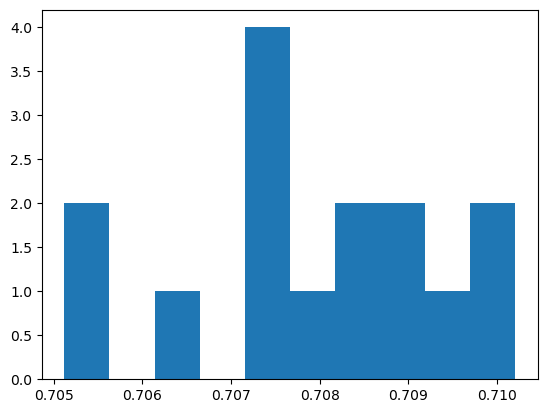

Gradient at the end of step 8 : [       nan 0.03345977 0.15947193 0.10456043 0.03842659 0.30590466
 0.08688791 0.11910323        nan        nan        nan 0.03297114
        nan 0.11608534 0.69036627 0.23659088 0.21101855 0.08985576
 0.28236923        nan 0.31366664 0.58723336 0.41700077 0.09242097
 0.05442641 0.5684723  0.5183296  0.3693618  0.19813621 0.15625651
 0.03172823        nan 0.40132818]
gk : rooOCeanUs1_ORF.15 lambda 0.69036627
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.15']

STEP 9 :
p_all tf.Tensor(-93822.57, shape=(), dtype=float32) -p_all tf.Tensor(93822.57, shape=(), dtype=float32)
Gradient at the end of step 8 : [       nan 0.03364137 0.15974432 0.10487823 0.03701919 0.30513284
 0.08711492 0.11955722        nan        nan        nan 0.03410613
        nan 0.11962654 0.6895945  0.23659088 0.20843075 0.09135395
 0.28236

Gradient at the end of step 9 : [       nan 0.03364137 0.15974432 0.10487823 0.03701919 0.30513284
 0.08711492 0.11955724        nan        nan        nan 0.03410613
        nan 0.11962654        nan 0.23659088 0.20843075 0.09135395
 0.28236923        nan 0.31144208 0.5864162  0.41663757 0.09219397
 0.0545172  0.5657937  0.52137136 0.36799982 0.19813621 0.15539391
 0.03172823        nan 0.40123737]
gk : rooOCeanUs1_ORF.22 lambda 0.5864162
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.22']

STEP 10 :
Gradient at the end of step 9 : [       nan 0.03364137 0.15974432 0.10483283 0.03815419 0.30127385
 0.08670631 0.11769584        nan        nan        nan 0.03451474
        nan 0.11880931        nan 0.23541048 0.21169955 0.09135395
 0.28264162        nan 0.31253168 0.5851904  0.41536635 0.09246637
 0.0544718  0.56670177 

Gradient at the end of step 10 : [       nan 0.03364137 0.15974432 0.10483283 0.03815419 0.30127385
 0.08670631 0.11769584        nan        nan        nan 0.03451474
        nan 0.11880931        nan 0.23541048 0.21169955 0.09135395
 0.28264165        nan 0.31253168        nan 0.41536635 0.09246637
 0.05447181 0.56670177 0.5217346  0.36886242 0.19686502 0.15643813
 0.03172823        nan 0.40160057]
gk : rooOCeanUs1_ORF.26 lambda 0.56670177
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.26']

STEP 11 :
Gradient at the end of step 10 : [       nan 0.03209777 0.15974432 0.10469663 0.03851739 0.30299905
 0.08688791 0.12110084        nan        nan        nan 0.03301654
        nan 0.11976273        nan 0.23554668 0.21160875 0.09017356
 0.28068945        nan 0.31275868        nan 0.41713697 0.0926933

Gradient at the end of step 11 : [       nan 0.03209777 0.15974432 0.10469663 0.03851739 0.30299905
 0.08688791 0.12110084        nan        nan        nan 0.03301654
        nan 0.11976273        nan 0.23554668 0.21160875 0.09017356
 0.28068945        nan 0.31275868        nan 0.41713697 0.09269337
 0.05469881        nan 0.52178    0.36645624 0.19736443 0.15612032
 0.03172823        nan 0.39928517]
gk : rooOCeanUs1_ORF.27 lambda 0.52178
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.27']

STEP 12 :
Gradient at the end of step 11 : [       nan 0.03250637 0.15974432 0.10456043 0.03824499 0.30445185
 0.08688791 0.11828604        nan        nan        nan 0.03315273
        nan 0.11890014        nan 0.23627308 0.20938414 0.09053676
 0.28350425        nan 0.31439307        nan 0

In [426]:
plt.hist([0.708436, 0.707301, 0.70911705, 0.7101612, 0.7051219, 0.70780045, 0.707301, 0.70879924, 0.70562124, 0.70966184, 0.7102066, 0.7071648, 0.70639306, 0.7075734, 0.70857227])

In [428]:
from scipy import stats

# H0: la liste suit une distribution normale
# H1: la liste ne suit pas une distribution normale
stat, p = stats.shapiro([0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798])

alpha = 0.05
if p > alpha:
    print("La liste suit une distribution normale (p=%.3f)" % (p))
else:
    print("La liste ne suit pas une distribution normale (p=%.3f)" % (p))


La liste suit une distribution normale (p=1.000)
p_all tf.Tensor(-97080.75, shape=(), dtype=float32) -p_all tf.Tensor(97080.75, shape=(), dtype=float32)
p_all tf.Tensor(-97080.75, shape=(), dtype=float32) -p_all tf.Tensor(97080.75, shape=(), dtype=float32)
p_all tf.Tensor(-97080.75, shape=(), dtype=float32) -p_all tf.Tensor(97080.75, shape=(), dtype=float32)
p_all tf.Tensor(-97080.766, shape=(), dtype=float32) -p_all tf.Tensor(97080.766, shape=(), dtype=float32)
p_all tf.Tensor(-97080.76, shape=(), dtype=float32) -p_all tf.Tensor(97080.76, shape=(), dtype=float32)
Gradient at the end of step 12 : [       nan 0.03364137 0.15974432 0.10487823 0.03738239 0.30340764
 0.08711491 0.11946644        nan        nan        nan 0.03233554
        nan 0.11962651        nan 0.23586448 0.20788595 0.09117235
 0.28205147        nan 0.31230468        nan 0.41722775 0.09187617
 0.05488041        nan        nan 0.36745504 0.19722822 0.15530312
 0.03172823        nan 0.40069255]
gk : rooOCeanUs1_ORF.23 la

Clean the script directory

In [21]:
os.system('rm -r rooOceanUs1_genome.fa_temp-orf')

0